In [1]:
import argparse
import logging
import math
import os
import random
import time
import cv2 as cv
from copy import deepcopy

from threading import Thread

import numpy as np
import torch.distributed as dist
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.utils.data

from torch.cuda import amp
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

import test  # import test.py to get mAP after each epoch
from models.experimental import attempt_load
from models.yolo import Model
from utils.autoanchor import check_anchors
from utils.datasets import create_dataloader
from utils.general import labels_to_class_weights, increment_path, labels_to_image_weights, init_seeds, \
    fitness, strip_optimizer, get_latest_run, check_dataset, check_file, check_git_status, check_img_size, \
    check_requirements, print_mutation, set_logging, one_cycle, colorstr
from utils.google_utils import attempt_download
from utils.loss import ComputeLoss
from utils.plots import plot_images, plot_labels, plot_results, plot_evolution
from utils.torch_utils import ModelEMA, select_device, intersect_dicts, torch_distributed_zero_first, is_parallel
from utils.wandb_logging.wandb_utils import WandbLogger, check_wandb_resume
from matplotlib import pyplot as plt

In [2]:
def img2label_paths(img_paths):
    # Define label paths as a function of image paths
    sa, sb = os.sep + 'images' + os.sep, os.sep + 'labels' + os.sep  # /images/, /labels/ substrings
    return ['txt'.join(x.replace(sa, sb, 1).rsplit(x.split('.')[-1], 1)) for x in img_paths]

In [3]:
cfg = 'cfg/yolov7-w6-pose.yaml'
data = 'data/coco_kpts.yaml'

In [4]:
import yaml

with open(data) as f:
    data_dict = yaml.safe_load(f)

train_path = data_dict['train']
test_path = data_dict['val']

In [5]:
from pathlib import Path

p = train_path

p = Path(p)
with open(p, 'r') as t:
    t = t.read().strip().splitlines()
    parent = str(p.parent) + os.sep
    jpg = [x.replace('./', parent) if x.startswith('./') else x for x in t]

img_formats = ['bmp', 'jpg', 'jpeg', 'png', 'tif', 'tiff', 'dng', 'webp', 'mpo']
img_files = [x.replace('/', os.sep).split(' ')[0] for x in jpg if x.split(' ')[0].split('.')[-1].lower() in img_formats]
label_files = img2label_paths(img_files)

In [6]:
# with open(random.choice(label_files)) as f:
#     l = [x.split() for x in f.read().strip().splitlines()]

In [7]:
import argparse
import json
import os
from pathlib import Path
from threading import Thread

import numpy as np
import torch
import yaml
from tqdm import tqdm

from models.experimental import attempt_load
from utils.datasets import create_dataloader
from utils.general import coco80_to_coco91_class, check_dataset, check_file, check_img_size, check_requirements, \
    box_iou, non_max_suppression, scale_coords, xyxy2xywh, xywh2xyxy, set_logging, increment_path, colorstr
from utils.metrics import ap_per_class, ConfusionMatrix
from utils.plots import plot_images, output_to_target, plot_study_txt
from utils.torch_utils import select_device, time_synchronized
import cv2

In [8]:
cache_path = (p if p.is_file() else Path(label_files[0]).parent).with_suffix('.cache') 
cache = torch.load(cache_path)
# cache = torch.load(str(cache_path)+'.bak')


In [9]:
single_cls = False
data = 'data/coco_kpts.yaml'

In [2]:
import matplotlib.pyplot as plt
import torch
import cv2
from torchvision import transforms
import numpy as np
from utils.datasets import letterbox
from utils.general import non_max_suppression
from utils.plots import output_to_target, plot_skeleton_kpts, plot_one_box
import random

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
weight = torch.load(
    '/mnt/purx/best.pt', 
    # 'weights/yolov7-w6-pose.pt',
    map_location=device)
model = weight['model']
_ = model.float().eval()

if torch.cuda.is_available():
    model.to(device)
    


In [3]:
# !git clone https://github.com/WongKinYiu/yolov7/ -b pose
file = '/mnt/purx/fyp/coco_kpts/images/train2017/000000559553.jpg'

image = cv2.imread(file)
image = letterbox(image, 960, stride=64, auto=True)[0]
image_ = image.copy()
image = transforms.ToTensor()(image)
image = torch.tensor(np.array([image.numpy()]))
image = image.to(device)

output, _ = model(image)

image = cv2.imread(file)
image = letterbox(image, 960, stride=64, auto=True)[0]
image_ = image.copy()
image = transforms.ToTensor()(image)
image = torch.tensor(np.array([image.numpy()]))

if torch.cuda.is_available():
    image = image.to(device)   
output, _ = model(image)

/home/shackleford/anaconda3/envs/yolov7/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


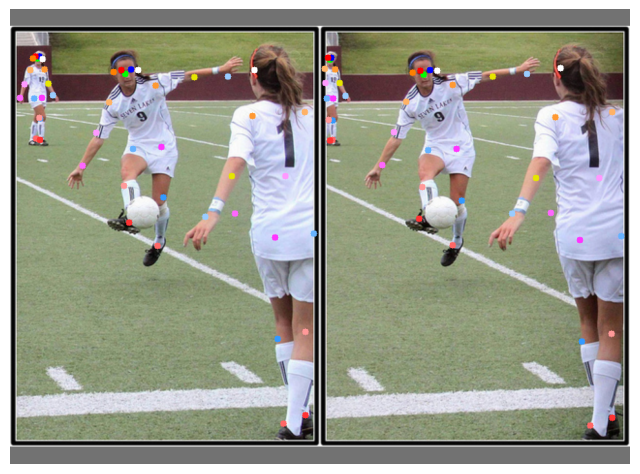

In [3]:
output = non_max_suppression(output, 0.25, 0.65, nc=model.yaml['nc'], nkpt=model.yaml['nkpt'], kpt_label=True)
with torch.no_grad():
    output = output_to_target(output)
nimg = image[0].permute(1, 2, 0) * 255
nimg = nimg.cpu().numpy().astype(np.uint8)
nimg = cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR)
for idx in range(output.shape[0]):
    plot_skeleton_kpts(nimg, output[idx, 7:].T, 3)
    plot_one_box(output[idx, ])
%matplotlib inline
plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(nimg)
plt.show()

In [5]:
output

array([[          0,           0,      45.082,      139.08,      61.606,       149.1,     0.91998,      42.287,      76.714,     0.96668,      45.891,      73.848,     0.91711,      39.437,      73.786,       0.921,      50.769,      77.536,     0.60415,      35.911,      76.294,     0.64497,      53.357,
             93.273,     0.93775,      31.561,      94.792,      0.9404,      59.955,      115.25,     0.86197,      22.031,      116.73,     0.87118,      66.967,      133.45,     0.81579,      15.623,      137.76,     0.83015,      49.421,      137.76,     0.95304,      37.686,      138.18,      0.9522,
             46.509,      169.69,     0.91193,      45.785,      168.77,     0.91464,       40.16,      200.56,     0.84801,      46.992,      202.25,     0.84656],
       [          0,           0,      845.43,      358.65,      218.37,      607.99,      0.8955,      845.09,      93.936,     0.20217,      844.72,      87.313,     0.13188,       848.7,      89.321,    0.011781,      

In [ ]:
kpt_name ={
    0: 'nose',
    # 1: 'l_eye',
    # 2: 'r_eye',
    # 3: 'l_ear',
    # 4: 'r_ear',
    5: 'l_shoulder',
    6: 'r_shoulder',
    7: 'l_elbow',
    8: 'r_elbow',
    9: 'l_wrist',
    10: 'r_wrist',
    11: 'l_hip',
    12: 'r_hip',
    7: 'l_knee',
    14: 'r_knee',
    15: 'l_ankle',
    16: 'r_ankle'
}

kpt_name ={
    0: 'nose',
    1: 'l_eye',
    2: 'r_eye',
    3: 'l_ear',
    4: 'r_ear',
    5: 'l_shoulder',
    6: 'r_shoulder',
    7: 'l_elbow',
    8: 'r_elbow',
    9: 'l_wrist',
    10: 'r_wrist',
    11: 'l_hip',
    12: 'r_hip',
    7: 'l_knee',
    14: 'r_knee',
    15: 'l_ankle',
    16: 'r_ankle'
}